In [1]:
import os
import math
import warnings
import itertools

import numpy as np
import plotly as py
import pandas as pd
import seaborn as sns
import plotly.tools as tls
import plotly.offline as pyo
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
def group_df_analyte(df, data_column="data"):
    df = df.pivot_table(
        values=data_column,
        # index=["sampleID_metadata", "panel_detail", "panel", "serostatus_delta_IgG"],
        index=["sampleID_metadata", "childhoodImmu", "panel_detail", "panel"],
        #index=["sampleID_metadata", "panel_detail", "panel"],
        columns=["analyte"],
        aggfunc="first",
        dropna=True,
    )

    df = df.dropna()

    df = df.reset_index(level=["panel_detail"])

    return df

In [3]:
def preprocess_data(
    df_in,
    antibody="IgG",
    sero_th="all",
    data_column="data",
    exclude_features=("None"),
):
    """
    Antibody: "IgG", "IgM", "IgM_IgG"
    sero_th: "all", "positive", "borderline positive"
    data_column: "data", "dataln"
    panel: "all", "acute", "epi"
    exclude_features: list of features we would like to exclude for example ["M1", "L1R"]
    """

    # Replace -inf with NaN
    df_in.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fow now filter antibody values
    if antibody == "IgM_IgG":
        # Filter out IgA or other analytes
        df_in = df_in[df_in["isotype"].isin(["IgM", "IgG"])]
        df_in["analyte"] = df_in["isotype"] + "_" + df_in["analyte"]
    else:
        df_in = df_in[df_in["isotype"] == antibody]
        df_in["analyte"] = df_in["isotype"] + "_" + df_in["analyte"]
    
    # Only select necessary columns, for now Analyte(s)
    df_in = df_in[
        [
            "sampleID_metadata",
            "panel_detail",
            "panel",
            "analyte",
            "childhoodImmu",
            data_column,
            "serostatus_cat.delta",
        ]
    ]

    # Add column for explicit serostatus of delta antigen
    df_in["serostatus_delta_IgG"] = df_in.apply(lambda x: x['serostatus_cat.delta'] if x["analyte"] == "IgG_Delta" else np.nan, axis=1)
    serostatus_IDs = df_in[df_in["serostatus_delta_IgG"].notna()]

    if sero_th == "positive":
        serostatus_IDs = serostatus_IDs[serostatus_IDs["serostatus_delta_IgG"].isin(["positive"])]
    elif sero_th == "borderline positive":
        serostatus_IDs = serostatus_IDs[
            serostatus_IDs["serostatus_delta_IgG"].isin(["borderline positive", "positive"])
        ]
    serostatus_IDs = serostatus_IDs["sampleID_metadata"].unique()



    print(
        f"ATTENTION: Dataframe includes {df_in.panel_detail.isna().sum()} rows with NaN values in panel_detail.\
        These will be excluded from further analysis."
    )

    # Drop NaN
    df_in = df_in[df_in["panel_detail"].notna()]

    # Group by patient ID so that we have analytes as columns
    df_out = group_df_analyte(df_in, data_column=data_column)

    # Drop column if in exclude_features
    # need to use endswith so it will work with IgM+IgG data
    # where columns look like this "IgM_M1", "IgG_M1", ..
    cols_to_drop = df_out.columns[df_out.columns.str.endswith(exclude_features)]
    df_out = df_out.drop(cols_to_drop, axis=1, errors="ignore")

    # Convert multi-index to columns
    df_out = df_out.reset_index()
    

    # Filter only for the serostatus of delta IgG
    if not sero_th == "all":
        df_out = df_out[df_out['sampleID_metadata'].isin(serostatus_IDs)]

    # Reset index
    df_out = df_out.set_index(["sampleID_metadata"])


    # drop this again
    # df_out = df_out.drop("serostatus_delta_IgG", axis=1)

    # Remove CPXV for now
    df_out = df_out[df_out["panel_detail"] != "CPXV"]

    # Extract the unknown samples as df_spox
    df_spox = df_out[df_out["panel_detail"] == "SPox"].drop(["panel"], axis=1)
    # extract the repetition panel
    df_rep = df_out[df_out["panel_detail"] == "SPox_Rep"].drop(["panel"], axis=1)
    # Add -rep to ID
    df_rep = df_rep.rename(index=lambda s: s + '-rep')
    # concat them both
    df_spox = pd.concat([df_spox, df_rep])

    
    # Replace Pre_New samples with Pre
    df_out.loc[df_out.panel_detail == "Pre_New", 'panel_detail'] = "Pre"

    # Remove the Spox and Spox_Rep columns
    df_out = df_out[df_out["panel_detail"] != "SPox"]
    df_out = df_out[df_out["panel_detail"] != "SPox_Rep"]

    df_out.loc[(df_out.childhoodImmu == 1) & (df_out.panel_detail == "Pre"), 'panel_detail'] = "PreVac"
    df_out.loc[(df_out.childhoodImmu == 1) & (df_out.panel_detail == "MVA"), 'panel_detail'] = "MVAVac"
    df_out.loc[(df_out.childhoodImmu == 1) & (df_out.panel_detail == "MPXV"), 'panel_detail'] = "MPXVVac"
    df_out = df_out.drop(["childhoodImmu"], axis=1)
    
    # Split to the three panels and drop the panel column, not needed anymore
    df_all = df_out.drop(["panel"], axis=1)
    df_acute = df_out[df_out["panel"] != "SPox"].drop(["panel"], axis=1)
    df_epi = df_out[df_out["panel"] == "SPox"].drop(["panel"], axis=1)

    #return df_all, df_acute, df_epi, df_spox
    return df_all, df_acute

In [4]:
#add path to your data
input_data = pd.read_csv("./dataInputAll.csv") # Change path if necessary
cols = list(input_data.columns)

C:\Users\akhmedovas\AppData\Local\Temp\ipykernel_12872\401675829.py:1: DtypeWarning:

Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
antibody_list = ["IgM_IgG", "IgG"]
sero_list = ["all"]
data_cols_list = [ "dataIn"]
exclusion_list = [("L1R", "M1", "VACV")] 
# k for k-fold cross validation
n_split = 5
# How often we want to repeat k-fold cross validation 
reps = 3
seed_runs = reps*n_split
start_seed = 70

In [6]:
d = {}
for antibody, sero_status, data_col, exclude_cols in itertools.product(
    antibody_list, sero_list, data_cols_list, exclusion_list
):
    df_all, df_acute = preprocess_data(
        input_data,
        antibody=antibody,
        sero_th=sero_status,
        data_column=data_col,
        exclude_features=exclude_cols,
    )
    # just for readability when saving files
    exclude_cols = "".join(exclude_cols)
    d[
        f"antibody_{antibody}_serostatus_{sero_status}_datacol_{data_col}_excluding_{exclude_cols}"
    ] = [df_all, df_acute]

C:\Users\akhmedovas\AppData\Local\Temp\ipykernel_12872\1627102853.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ATTENTION: Dataframe includes 0 rows with NaN values in panel_detail.        These will be excluded from further analysis.


C:\Users\akhmedovas\AppData\Local\Temp\ipykernel_12872\1627102853.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ATTENTION: Dataframe includes 0 rows with NaN values in panel_detail.        These will be excluded from further analysis.


In [7]:
df_all, df_acute = d['antibody_IgG_serostatus_all_datacol_dataIn_excluding_L1RM1VACV']

In [8]:
df_all

analyte,panel_detail,IgG_A27L,IgG_A29,IgG_A33R,IgG_A35R,IgG_A5L,IgG_ATI-C,IgG_ATI-N,IgG_B5R,IgG_B6,IgG_D8L,IgG_Delta,IgG_E8,IgG_H3L
sampleID_metadata,,,,,,,,,,,,,,
NK-01,PreVac,3.007376,2.308000,2.621740,2.744368,3.192777,2.681299,1.991755,2.320223,2.125460,2.258205,2.204926,2.370427,3.095005
NK-02,PreVac,3.213159,3.329500,3.078741,3.214265,3.910161,3.985346,2.281649,3.330912,2.770951,2.890988,2.805364,3.587633,3.492192
NK-03,PreVac,2.923323,2.824320,3.276149,3.321151,4.238981,3.130236,2.001769,2.668334,2.814008,3.508056,2.577387,3.901386,3.418208
NK-04,PreVac,2.497263,1.831758,3.134182,3.417015,3.421399,3.453381,2.379945,2.365963,2.361558,2.569704,2.215244,2.629439,3.477203
NK-05,PreVac,3.531505,3.068375,3.757479,3.879277,3.593687,3.194305,2.089256,3.043314,2.837206,3.297521,2.635205,3.689836,3.208375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S-20-004-015-03,MVA,2.949904,2.072551,2.995726,3.038549,3.390470,4.259930,1.599709,3.681851,3.473145,3.877128,2.777034,3.806442,2.836117
S-20-004-026-01,Pre,3.174743,2.334080,2.259939,1.914257,3.960502,3.901381,1.657356,1.348243,0.999225,2.029349,1.300198,1.552349,2.811648
S-20-004-026-02,MVA,3.151743,2.758053,2.461842,2.213412,3.936587,3.840432,1.824147,2.055972,1.938735,2.715570,1.699702,2.438785,2.808652


In [9]:
df_acute

analyte,panel_detail,IgG_A27L,IgG_A29,IgG_A33R,IgG_A35R,IgG_A5L,IgG_ATI-C,IgG_ATI-N,IgG_B5R,IgG_B6,IgG_D8L,IgG_Delta,IgG_E8,IgG_H3L
sampleID_metadata,,,,,,,,,,,,,,
NK-01,PreVac,3.007376,2.308000,2.621740,2.744368,3.192777,2.681299,1.991755,2.320223,2.125460,2.258205,2.204926,2.370427,3.095005
NK-02,PreVac,3.213159,3.329500,3.078741,3.214265,3.910161,3.985346,2.281649,3.330912,2.770951,2.890988,2.805364,3.587633,3.492192
NK-03,PreVac,2.923323,2.824320,3.276149,3.321151,4.238981,3.130236,2.001769,2.668334,2.814008,3.508056,2.577387,3.901386,3.418208
NK-04,PreVac,2.497263,1.831758,3.134182,3.417015,3.421399,3.453381,2.379945,2.365963,2.361558,2.569704,2.215244,2.629439,3.477203
NK-05,PreVac,3.531505,3.068375,3.757479,3.879277,3.593687,3.194305,2.089256,3.043314,2.837206,3.297521,2.635205,3.689836,3.208375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S-20-004-015-03,MVA,2.949904,2.072551,2.995726,3.038549,3.390470,4.259930,1.599709,3.681851,3.473145,3.877128,2.777034,3.806442,2.836117
S-20-004-026-01,Pre,3.174743,2.334080,2.259939,1.914257,3.960502,3.901381,1.657356,1.348243,0.999225,2.029349,1.300198,1.552349,2.811648
S-20-004-026-02,MVA,3.151743,2.758053,2.461842,2.213412,3.936587,3.840432,1.824147,2.055972,1.938735,2.715570,1.699702,2.438785,2.808652


In [10]:
#df_all and df_acute are the same when childhoodImmu is included

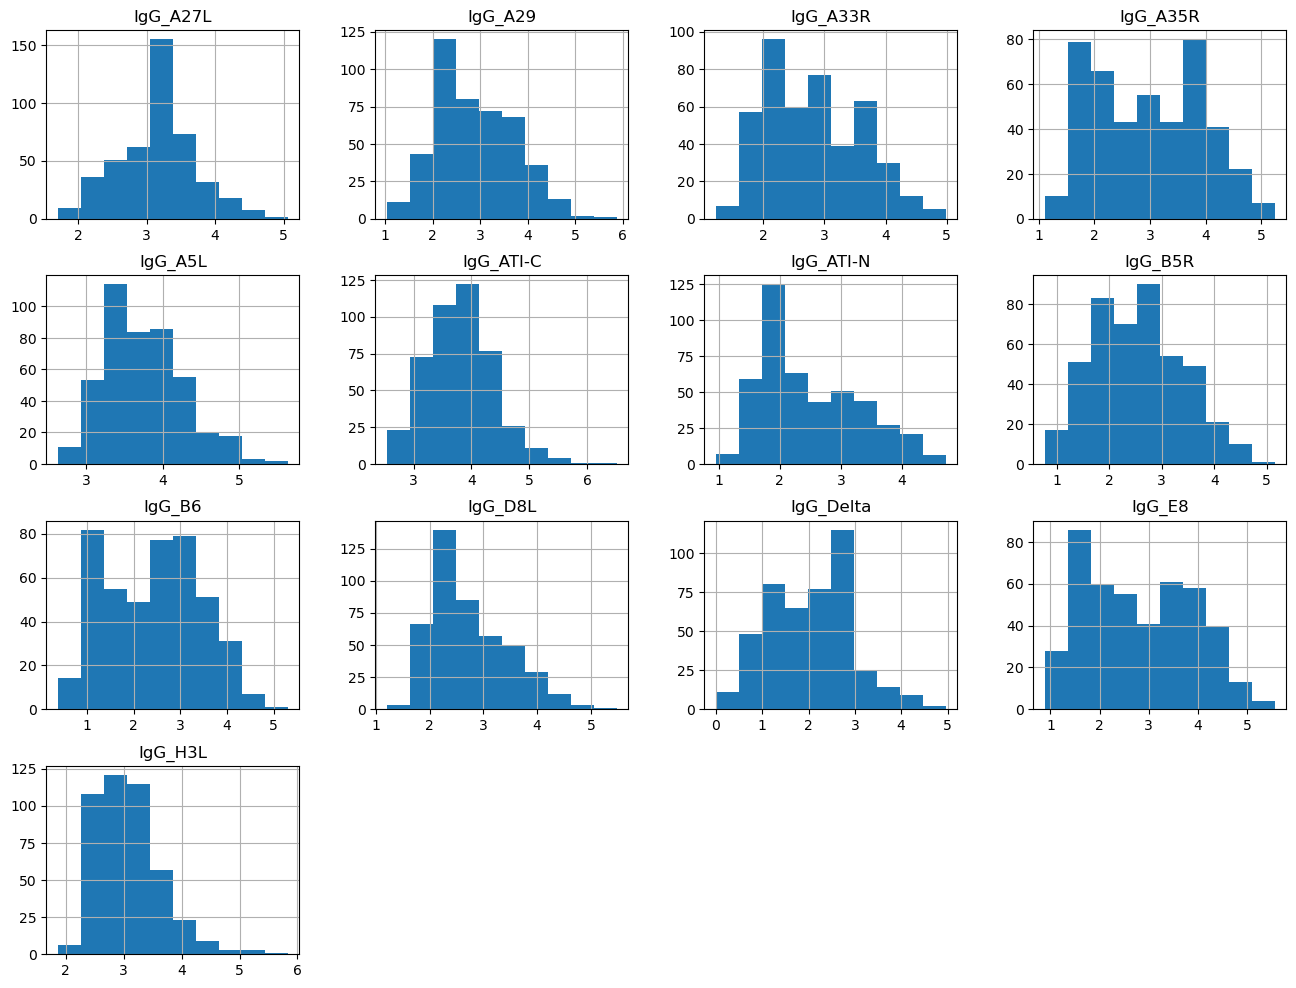

In [11]:
# Visulize some proberties of the df_igg_table
df_acute.hist(figsize=(16, 12));

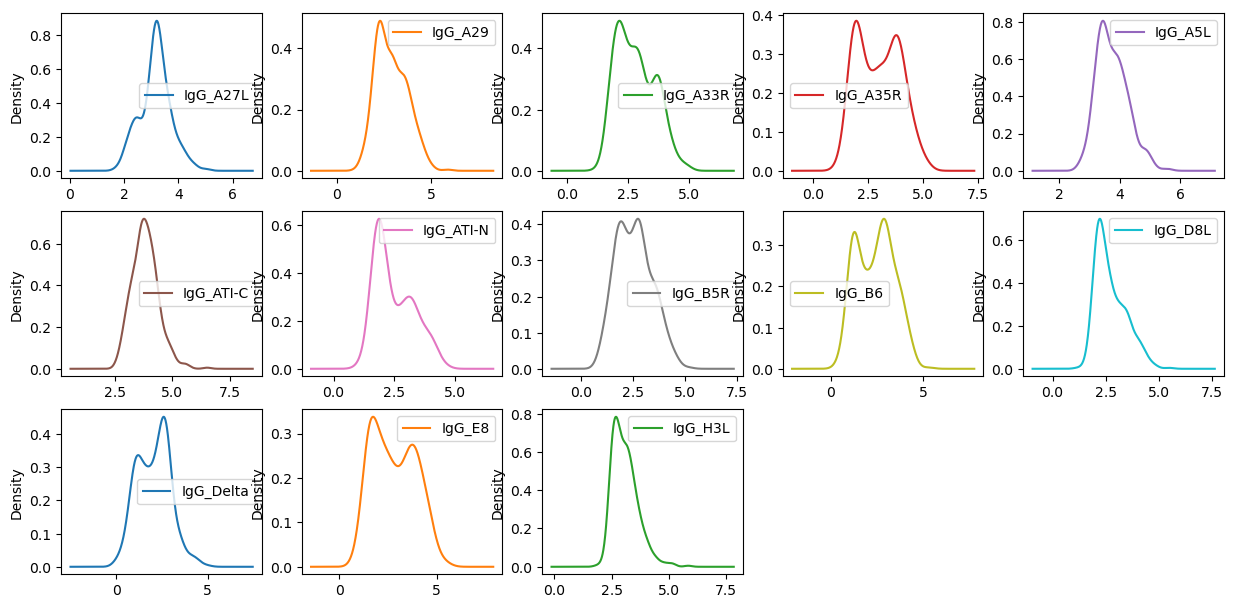

In [12]:
df_acute.plot(kind="density", layout=(6,5), 
             subplots=True,sharex=False, sharey=False, figsize=(15,15));

In [13]:
df_acute.describe().T

,count,mean,std,min,25%,50%,75%,max
analyte,,,,,,,,
IgG_A27L,446.0,3.160913,0.564361,1.706582,2.869729,3.188363,3.472522,5.059643
IgG_A29,446.0,2.894140,0.819208,1.040134,2.234771,2.803522,3.505515,5.875116
IgG_A33R,446.0,2.819358,0.781553,1.230027,2.156093,2.747322,3.470157,4.984580
IgG_A35R,446.0,2.972551,0.963524,1.107530,2.027716,2.998969,3.779306,5.244706
IgG_A5L,446.0,3.753348,0.509269,2.627643,3.377923,3.689908,4.080880,5.637730
IgG_ATI-C,446.0,3.809733,0.570999,2.536786,3.437005,3.777725,4.148973,6.513826
IgG_ATI-N,446.0,2.500280,0.810232,0.951382,1.827253,2.223688,3.160953,4.717248
IgG_B5R,446.0,2.553363,0.847924,0.769472,1.867057,2.538498,3.108759,5.154036
IgG_B6,446.0,2.414271,1.001552,0.367308,1.436590,2.519417,3.146951,5.308799


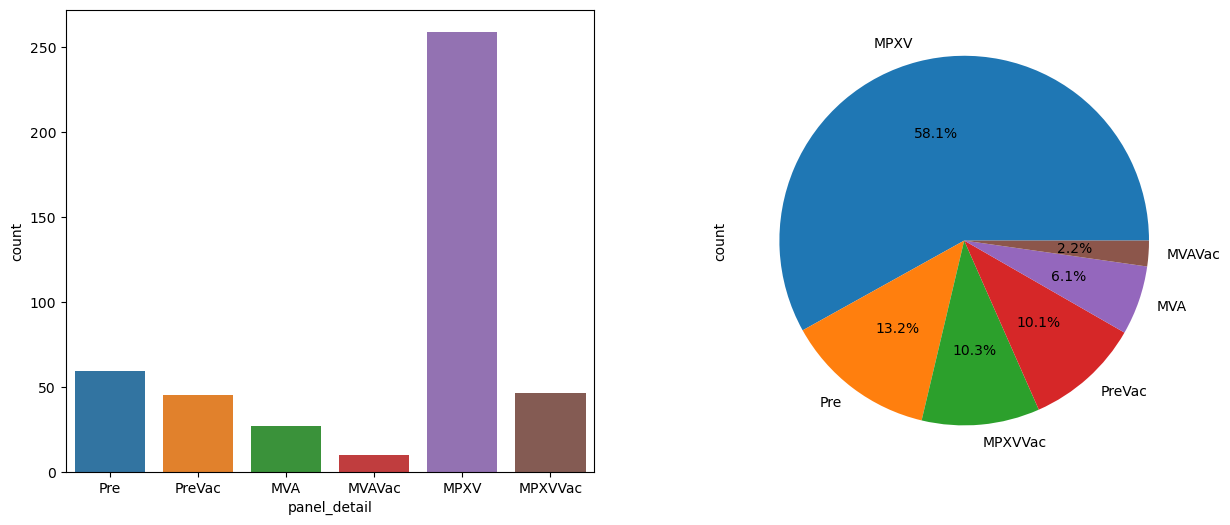

In [14]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='panel_detail', data=df_acute, ax=ax[0], order=["Pre", "PreVac", "MVA", "MVAVac", "MPXV", "MPXVVac"])
_ = df_all['panel_detail'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

C:\Program Files\Anaconda3\envs\jupyter_tf\lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



<Axes: xlabel='analyte', ylabel='analyte'>

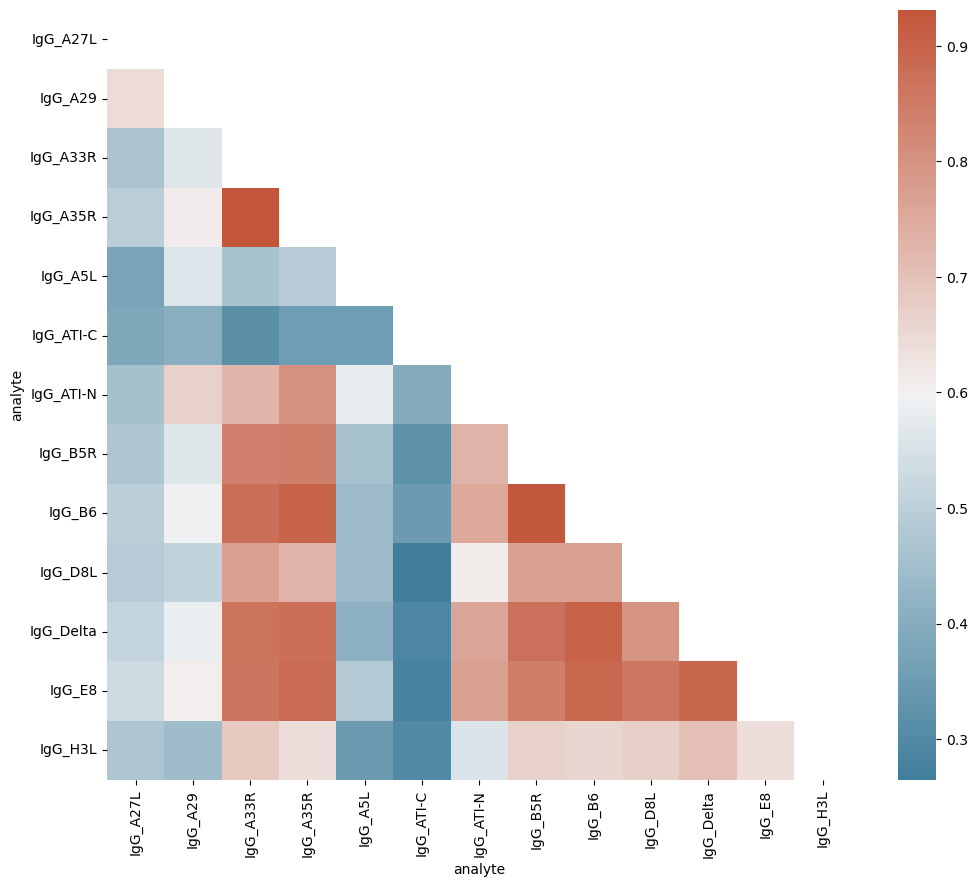

In [15]:
corr = df_acute.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [16]:
y_data = df_acute.iloc[:, 0]
x_data = df_acute.iloc[:, 1:]

unique = df_acute["panel_detail"].unique()
print(unique)

['PreVac' 'Pre' 'MPXVVac' 'MPXV' 'MVA' 'MVAVac']


In [17]:
#T-SNE with two dimensions
tsne_2d = TSNE(n_components=2, perplexity=50)
TCs_2d = tsne_2d.fit_transform(x_data)

dataset = x_data
dataset["panel_detail"] = y_data
dataset["TC1_2d"] = TCs_2d[:, 0]
dataset["TC2_2d"] = TCs_2d[:, 1]

clusters = []
traces = []

for i in range(len(unique)):
    clusters.append(dataset[dataset["panel_detail"] == unique[i]])

for i in range(len(unique)):
    trace = go.Scatter(
                    x = clusters[i]["TC1_2d"],
                    y = clusters[i]["TC2_2d"],
                    mode = "markers",
                    name = "class "f"{unique[i]}",
                    marker = dict(color = i),
                    text = None)
    traces.append(trace)
    
title = "Visualizing All Classes in Two Dimensions Using T-SNE"

layout = dict(title = title,
              xaxis = dict(title = 'TC1',ticklen = 5,zeroline = False),
              yaxis = dict(title = 'TC2',ticklen = 5,zeroline = False)
             )

fig = go.Figure(dict(data=traces, layout=layout))

fig.write_html("2d_tsne_mpox_all.html")

traces_Pre = []

for i in range(len(unique)):
    if unique[i] == "Pre" or unique[i] == "PreVac":
        trace = go.Scatter(
                        x = clusters[i]["TC1_2d"],
                        y = clusters[i]["TC2_2d"],
                        mode = "markers",
                        name = "class "f"{unique[i]}",
                        marker = dict(color = i),
                        text = None)
        traces_Pre.append(trace)

title = "Visualizing Pre Classes in Two Dimensions Using T-SNE"

layout = dict(title = title,
              xaxis = dict(title = 'TC1',ticklen = 5,zeroline = False),
              yaxis = dict(title = 'TC2',ticklen = 5,zeroline = False)
             )

fig = go.Figure(dict(data=traces_Pre, layout=layout))

fig.write_html("2d_tsne_mpox_pre.html")

traces_MVA = []

for i in range(len(unique)):
    if unique[i] == "MVA" or unique[i] == "MVAVac":
        trace = go.Scatter(
                        x = clusters[i]["TC1_2d"],
                        y = clusters[i]["TC2_2d"],
                        mode = "markers",
                        name = "class "f"{unique[i]}",
                        marker = dict(color = i),
                        text = None)
        traces_MVA.append(trace)

title = "Visualizing MVA Classes in Two Dimensions Using T-SNE"

layout = dict(title = title,
              xaxis = dict(title = 'TC1',ticklen = 5,zeroline = False),
              yaxis = dict(title = 'TC2',ticklen = 5,zeroline = False)
             )

fig = go.Figure(dict(data=traces_MVA, layout=layout))

fig.write_html("2d_tsne_mpox_mva.html")

traces_MPXV = []

for i in range(len(unique)):
    if unique[i] == "MPXV" or unique[i] == "MPXVVac":
        trace = go.Scatter(
                        x = clusters[i]["TC1_2d"],
                        y = clusters[i]["TC2_2d"],
                        mode = "markers",
                        name = "class "f"{unique[i]}",
                        marker = dict(color = i),
                        text = None)
        traces_MPXV.append(trace)

title = "Visualizing MPXV Classes in Two Dimensions Using T-SNE"

layout = dict(title = title,
              xaxis = dict(title = 'TC1',ticklen = 5,zeroline = False),
              yaxis = dict(title = 'TC2',ticklen = 5,zeroline = False)
             )

fig = go.Figure(dict(data=traces_MPXV, layout=layout))

fig.write_html("2d_tsne_mpox_mpxv.html")

In [18]:
x_data = df_acute.iloc[:, 1:]

In [19]:
#LDA with two dimensions
lda = LDA(n_components=2)
LDA_2d = lda.fit_transform(x_data, y_data)

dataset = x_data
dataset["panel_detail"] = y_data
dataset["LDA1_2d"] = LDA_2d[:, 0]
dataset["LDA2_2d"] = LDA_2d[:, 1]

clusters = []
traces = []

for i in range(len(unique)):
    clusters.append(dataset[dataset["panel_detail"] == unique[i]])

for i in range(len(unique)):
    trace = go.Scatter(
                    x = clusters[i]["LDA1_2d"],
                    y = clusters[i]["LDA2_2d"],
                    mode = "markers",
                    name = "class "f"{unique[i]}",
                    marker = dict(color = i),
                    text = None)
    traces.append(trace)
    
title = "Visualizing Classes in Two Dimensions Using LDA"

layout = dict(title = title,
              xaxis = dict(title = 'LDA1',ticklen = 5, zeroline = False),
              yaxis = dict(title = 'LDA2',ticklen = 5, zeroline = False)
             )

fig = go.Figure(dict(data=traces, layout=layout))

fig.write_html("2d_lda_mpox_all.html")

traces_Pre = []

for i in range(len(unique)):
    if unique[i] == "Pre" or unique[i] == "PreVac":
        trace = go.Scatter(
                        x = clusters[i]["LDA1_2d"],
                        y = clusters[i]["LDA2_2d"],
                        mode = "markers",
                        name = "class "f"{unique[i]}",
                        marker = dict(color = i),
                        text = None)
        traces_Pre.append(trace)

title = "Visualizing Pre Classes in Two Dimensions Using LDA"

layout = dict(title = title,
              xaxis = dict(title = 'LDA1',ticklen = 5, zeroline = False),
              yaxis = dict(title = 'LDA2',ticklen = 5, zeroline = False)
             )

fig = go.Figure(dict(data=traces_Pre, layout=layout))

fig.write_html("2d_lda_mpox_pre.html")

traces_MVA = []

for i in range(len(unique)):
    if unique[i] == "MVA" or unique[i] == "MVAVac":
        trace = go.Scatter(
                        x = clusters[i]["LDA1_2d"],
                        y = clusters[i]["LDA2_2d"],
                        mode = "markers",
                        name = "class "f"{unique[i]}",
                        marker = dict(color = i),
                        text = None)
        traces_MVA.append(trace)

title = "Visualizing MVA Classes in Two Dimensions Using LDA"

layout = dict(title = title,
              xaxis = dict(title = 'LDA1',ticklen = 5, zeroline = False),
              yaxis = dict(title = 'LDA2',ticklen = 5, zeroline = False)
             )

fig = go.Figure(dict(data=traces_MVA, layout=layout))

fig.write_html("2d_lda_mpox_mva.html")

traces_MPXV = []

for i in range(len(unique)):
    if unique[i] == "MPXV" or unique[i] == "MPXVVac":
        trace = go.Scatter(
                        x = clusters[i]["LDA1_2d"],
                        y = clusters[i]["LDA2_2d"],
                        mode = "markers",
                        name = "class "f"{unique[i]}",
                        marker = dict(color = i),
                        text = None)
        traces_MPXV.append(trace)

title = "Visualizing MPXV Classes in Two Dimensions Using LDA"

layout = dict(title = title,
              xaxis = dict(title = 'LDA1',ticklen = 5,zeroline = False),
              yaxis = dict(title = 'LDA2',ticklen = 5,zeroline = False)
             )

fig = go.Figure(dict(data=traces_MPXV, layout=layout))

fig.write_html("2d_lda_mpox_mpxv.html")

In [20]:
x_data = df_acute.iloc[:, 1:]
x_data = df_acute.drop("panel_detail", axis=1)

X = x_data.values
X_std = StandardScaler().fit_transform(X)

# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [21]:
trace1 = go.Scatter(
                    x = list(range(17)),
                    y = cum_var_exp,
                    mode = 'lines+markers',
                    name = "Cumulative Explained Variance",
                    line=dict(
                        shape='spline',
                        color = 'goldenrod'
                    )
                )

trace2 = go.Scatter(
                    x = list(range(17)),
                    y = var_exp,
                    mode = 'lines+markers',
                    name = "Individual Explained Variance",
                    line=dict(
                        shape='linear',
                        color = 'black'
                    )
                )

title = "Visualizing Cumulative and Individual Explained Variance"

layout = dict(title = title,
              xaxis= dict(title= 'Features',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Values',ticklen= 5,zeroline= False)
             )
fig = go.Figure(dict(data=[trace1, trace2], layout=layout))

fig.write_html("variance_mpox.html")